# Introduction

Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

## About the data

The dataset you will be working with is called Emo-DB and can be found [here](http://emodb.bilderbar.info/index-1280.html).

It is a database containing samples of emotional speech in German. It contains samples labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information")
   
The goal of this project is to develop a model which is able to **classify samples of emotional speech**. Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!

## Deliverable

The end-goal is to deliver us a zip file containing:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work
* A Dockerfile which defines a container for the project. The container should handle everything (download the data, run the code, etc...). When running the container it should expose the jupyter notebook on one port and expose a Flask API on another one. The Flask app contains two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* A README.md which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* Any necessary .py, .sh or other files needed to run your code.

# Libraries Loading

In [1]:
%load_ext lab_black

In [91]:
import glob
from scipy.io import wavfile
import skorch
from skorch import callbacks
from sklearn.metrics import accuracy_score
import os
from skorch import NeuralNetClassifier
import numpy as np
from skorch.callbacks import EpochScoring
import torch
import torch.nn as nn
import seaborn as sns
from keras.utils import np_utils
from matplotlib.ticker import MaxNLocator

sns.set()
import torch.optim as optim
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from flask import render_template
import traceback
from datetime import datetime
import pickle
import pandas as pd
from IPython.core.debugger import set_trace
from sklearn.model_selection import GridSearchCV
from speechpy.feature import mfcc
from sklearn.metrics import confusion_matrix
import sys
from sklearn.preprocessing import StandardScaler

sys.path.insert(1, "./src")
from misc_funcs import (
    MAIN_DIR,
    DATA_DIR,
    WAV_DIR,
    MFCC_DIR,
    MODEL_DIR,
    DE2EN,
    EN2DE,
    EN2NUM,
    NUM2EN,
    FULL_EM,
    DE2NUM,
    load_wav_data,
    get_mfcc,
    save_mfcc_data,
    load_mfcc_data,
    load_pd_data,
    SPEAKER_DATA
)
from model import CNN_classif, train_model, run_model
from visualisation import plot_metrics,vis_sample

sys.path.insert(1, "./lib/pytorch-cnn-visualizations/src/")
from generate_class_specific_samples import ClassSpecificImageGeneration

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'
COLOR_PALETTE = ["#f9ed69", "#f08a5d", "#b83b5e", "#00adb5", "#6a2c70", "#393e46"]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preparation & Cleaning

In [86]:
data_df = load_pd_data()

## Wav length 

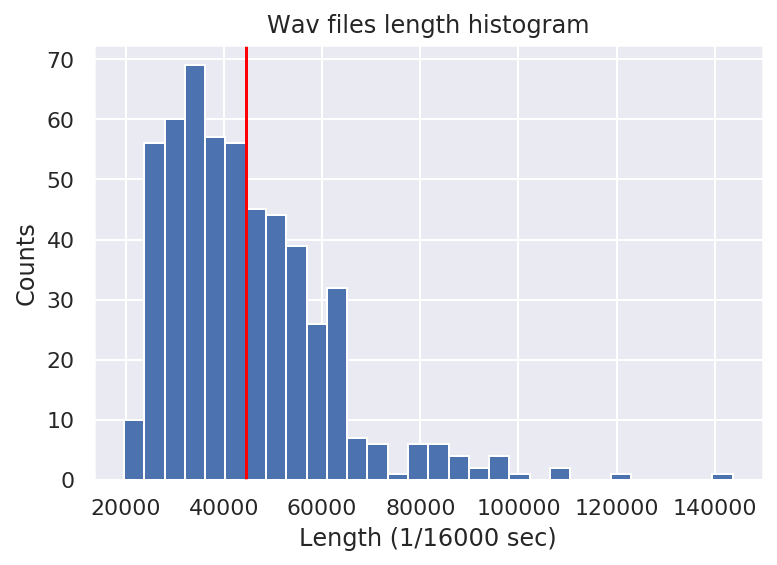

In [83]:
data_df['len'] = data_df.data.apply(len)
mean = data_df.len.mean()
data_df.len.hist(bins=30)
plt.title('Wav files length histogram')
plt.xlabel('Length (1/16000 sec)')
plt.ylabel('Counts')
plt.axvline(x=mean,color='red')

<div class="alert alert-block alert-info">
As we can see, most of the data is centered around the mean, despite a few outliers around 140000.
</div>

## Sex 

In [34]:
data_df.sex.value_counts()

female    302
male      233
Name: sex, dtype: int64

<div class="alert alert-block alert-info">
The dataset looks pretty balanced in terms of sex.
</div>

## Emotion Types

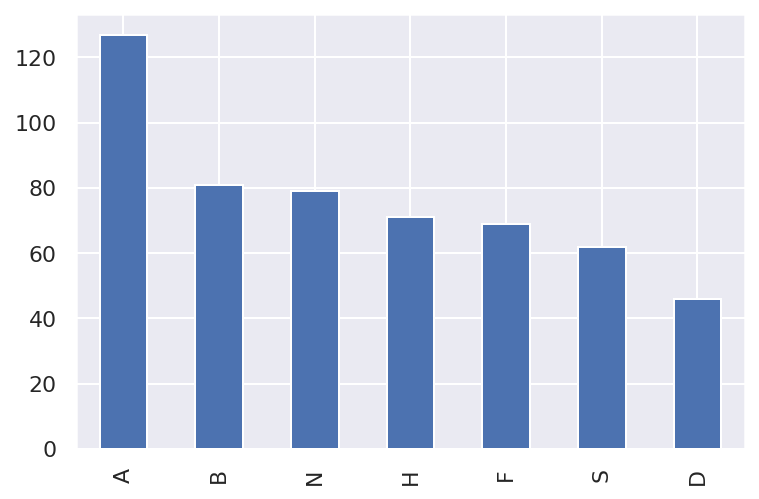

In [38]:
data_df.emotion.value_counts().plot.bar()

<div class="alert alert-block alert-info">
A small unbalance is present: this motivates us to normalize these during the data augmentation phase, in order to make the accuracy a valid metric
</div>

## Sex-emotion imbalance 

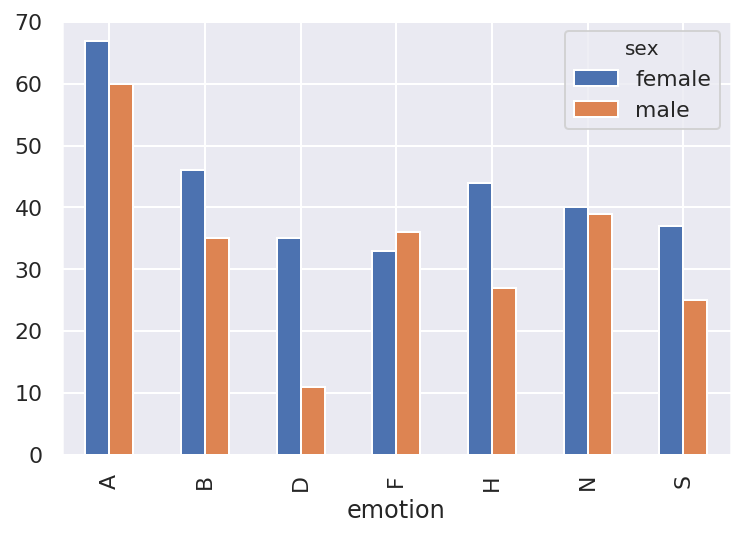

In [64]:
emo_sex = data_df.groupby(['emotion','sex'])['len']\
         .count()\
         .to_frame()\
         .reset_index(level=1)\
         .pivot(columns='sex',values='len')

emo_sex.plot.bar()

<div class="alert alert-block alert-info">
The sex bias looks acceptable: indeed, if a strong imbalance was present in the dataset amongst emotion (say for instance that the fear was acted mostly by men and the anger by women) this could have lead the models to learn the wrong features: i.e to recognize the sex instead of the emotions.
</div>

In [31]:
# we first load the wav data as a numpy array
file_names, sfs, data, targets = load_wav_data()
# and use its mfcc structure
file_names_f,data_f,targets_f = get_mfcc(data, sfs,targets,file_names)
# save it for quicker load the next time
save_mfcc_data(file_names, data_f, targets_f)

Saving done!


<div class="alert alert-block alert-info">
We use the mfcc COMPLETE
In order to reduce overfitting some data augmentation is performed COMPLETE
</div>

# Feature Engineering & Modeling

<div class="alert alert-block alert-info">
Two main architectures were tested:CNN and LSTM. Both of them were hyper-parameter-optimized by GridSearch using skorch.
</div>

## CNN

### Grid Search

In [68]:
model = CNN_classif()
params = {
    "lr":np.logspace(-4,-1,4),
    "optimizer": [optim.SGD,optim.Adam,optim.AdamW],
    "criterion":[nn.CrossEntropyLoss,nn.NLLLoss]
}
call1 = EpochScoring(on_train=True, lower_is_better=False, scoring=accuracy_score)
net_gs = NeuralNetClassifier(model.double(), max_epochs=8,batch_size=20,callbacks=[call1])
gs = GridSearchCV(net_gs, params, refit=False, cv=2, scoring="accuracy", verbose=2,)

In [69]:
gs.fit(data_f.astype(np.double), targets)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, lr=0.0001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__nesterov=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    accuracy_score    train_loss    valid_acc    valid_loss      dur
-------  ----------------  ------------  -----------  ------------  -------
      1            0.1286        2.0086       0.1091        1.9507  14.5692
      2            0.2048        1.9925       0.2364        1.9592  13.2671
      3            0.1762        1.9995       0.1818        1.9744  13.4994
      4            0.1429        1.9890       0.1818        1.9867  13.2704
      5            0.1714        1.9910       0.1636        1.9912  13.2488
      6            0.1571        1.9876       0.1455        1.9919  13.2420
      7            0.1667        1.9665       0.1455        1.9916  13.2976
      8            0.1667        1.9638       0.1455        1.9906  13.3670
[CV]  criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, lr=0.0001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__nesterov=False, total= 1.9min
[CV] criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, lr=0.0001, optim

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


  epoch    accuracy_score    train_loss    valid_acc    valid_loss      dur
-------  ----------------  ------------  -----------  ------------  -------
      1            0.1643        2.0035       0.0877        1.9526  13.4195
      2            0.1268        2.0088       0.1228        1.9601  13.3877
      3            0.1033        1.9943       0.1404        1.9707  13.4477
      4            0.1362        1.9963       0.1404        1.9753  13.7443
      5            0.1408        1.9844       0.1579        1.9768  13.4602
      6            0.1268        1.9897       0.1579        1.9763  13.5034
      7            0.1362        1.9872       0.1579        1.9753  13.4764
      8            0.1596        1.9668       0.1579        1.9741  13.4500
[CV]  criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, lr=0.0001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__nesterov=False, total= 1.9min
[CV] criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, lr=0.0001, optim

ValueError: Nesterov momentum requires a momentum and zero dampening

In [6]:
with open("models/CNN_gridsearch.pkl",'wb') as f:
    pickle.dump(gs,f)

### Training Best Model

In [27]:
model = CNN_classif()
call1 = EpochScoring(on_train=True, lower_is_better=False, scoring=accuracy_score)
call2 = callbacks.Checkpoint(
    monitor="valid_acc_best", f_optimizer=None, f_history=None, dirname="grid_search/"
)
net = NeuralNetClassifier(
    model.double(),
    batch_size=20,
    max_epochs=20,
    lr=1e-4,
    train_split=skorch.dataset.CVSplit(5),
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    callbacks=[call1, call2]
)

In [27]:
net.fit(data_f.astype(np.double), targets)

In [6]:
with open("models/best_cnn.pkl",'wb') as f:
    pickle.dump(net,f)

## LSTM

### Grid Search

In [31]:
from model import get_LSTM
clf = KerasClassifier(get_LSTM)
optimizers  = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
params ={'optimizer'=optimizers, epochs=epochs, batch_size=batches, init=init}

gs = GridSearchCV(estimator=clf, params, refit=False, cv=3, scoring="accuracy", verbose=1,)

In [31]:
modeltf2 = gen_lstm()

In [32]:
x_tf = np.squeeze(data_f)
y_tf = np_utils.to_categorical(targets)

In [33]:
history = modeltf2.fit(
    x_tf,
    y_tf,
    batch_size=20,
    epochs=60,
)

Epoch 1/60
535/535 [==============================] - 34s 63ms/step - loss: 0.4379 - accuracy: 0.8531
Epoch 2/60
240/535 [============>.................] - ETA: 16s - loss: 0.3973 - accuracy: 0.8571

KeyboardInterrupt: 

In [6]:
with open("models/LSTM_gridsearch.pkl",'wb') as f:
    pickle.dump(gs,f)

### Training Best Model

In [41]:
file_names,sfs,data,targets = load_wav_data()
data_f = get_mfcc(data,sfs)
save_mfcc_data(file_names,data_f,targets)
file_names,data_f,targets = load_mfcc_data('./data/mfcc')

Saving done!


In [6]:
with open("models/LSTM_best_model.pkl",'wb') as f:
    pickle.dump(net,f)

# Results & Visualizations

## CNN

In [ ]:
with open("models/NNoverfit.pkl",'rb') as f:
    net_overfit = pickle.load(f)

### Train-Validation Metrics

In [90]:
#TODO

### Confusion Matrix

In [90]:
#TODO

### Max Image Activation

<div class="alert alert-block alert-info">
As we use CNN and perform decently, it becomes potentially possible to perform some feature visualization, in our case to visualize which image input stimulates the most a given output class. This is done by performing gradient descent on the pixels values and defining the loss function as the negative output value of a given label in the final layer.
    
Ideally, this should generate an image which represent well the class of corresponding images (sounds in our case) if the network has indeed reached a decent validation accuracy.
</div>

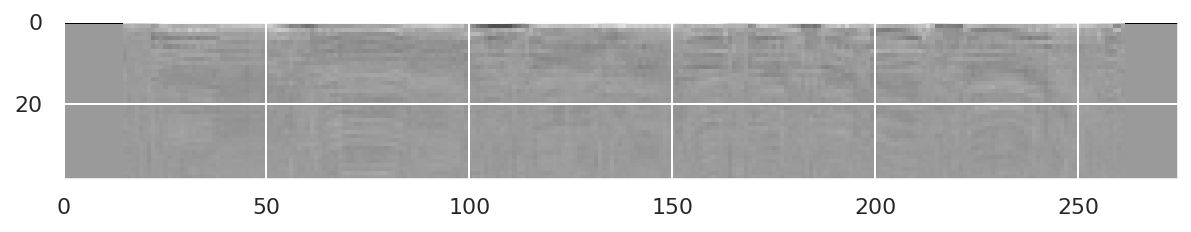

In [302]:
vis_sample(data_f[21, 0])

In [308]:
model.load_state_dict(torch.load("models/00_00_0000"))

<All keys matched successfully>

In [309]:
results = []
for i in range(7):
    csig = ClassSpecificImageGeneration(model, i)
    result = csig.generate(iterations=150)
    result = result[0, 0].detach().numpy()
    results.append(result)

Iteration: 10 Loss 1.52
Iteration: 20 Loss 1.07
Iteration: 30 Loss 0.91
Iteration: 40 Loss 0.81
Iteration: 50 Loss 0.75
Iteration: 60 Loss 0.72
Iteration: 70 Loss 0.70
Iteration: 80 Loss 0.66
Iteration: 90 Loss 0.69
Iteration: 100 Loss 0.67
Iteration: 110 Loss 0.65
Iteration: 120 Loss 0.63
Iteration: 130 Loss 0.62
Iteration: 140 Loss 0.63
Iteration: 149 Loss 0.59
Iteration: 10 Loss -0.39
Iteration: 20 Loss -0.65
Iteration: 30 Loss -0.77
Iteration: 40 Loss -0.83
Iteration: 50 Loss -0.88
Iteration: 60 Loss -0.92
Iteration: 70 Loss -0.94
Iteration: 80 Loss -0.97
Iteration: 90 Loss -0.98
Iteration: 100 Loss -1.00
Iteration: 110 Loss -1.02
Iteration: 120 Loss -1.03
Iteration: 130 Loss -1.04
Iteration: 140 Loss -1.05
Iteration: 149 Loss -1.05
Iteration: 10 Loss -0.01
Iteration: 20 Loss -0.28
Iteration: 30 Loss -0.42
Iteration: 40 Loss -0.51
Iteration: 50 Loss -0.58
Iteration: 60 Loss -0.62
Iteration: 70 Loss -0.65
Iteration: 80 Loss -0.68
Iteration: 90 Loss -0.70
Iteration: 100 Loss -0.71
It

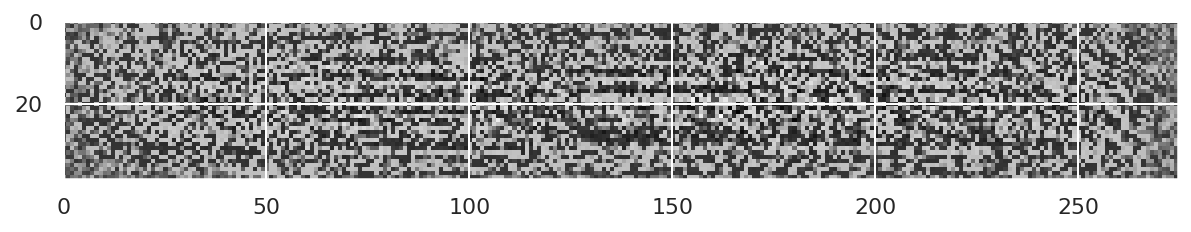

In [378]:
vis_sample(results[3])

<div class="alert alert-block alert-info">
Two problems were encountered: first, the chosen library does not allow for reverse mfcc transforms. Then, the network did not reach a high enough validation accuracy to generate meaningful images. Due to time constraints, this part of the project was no longer developped. 
</div>

## LSTM

In [6]:
with open("models/LSTM_best_model.pkl",'wb') as f:
    pickle.dump(net,f)

### Train-Validation Metrics

In [90]:
#TODO

### Confusion Matrix

In [90]:
#TODO